Early stopping at step 399, final point: tensor([0.9998, 1.9996]), grad norm: 0.000997
Elapsed time: 0.15 seconds
Loss < 1.0 reached at iteration 23
Loss < 0.1 reached at iteration 80
Loss < 0.01 reached at iteration 137
Loss < 0.001 reached at iteration 194


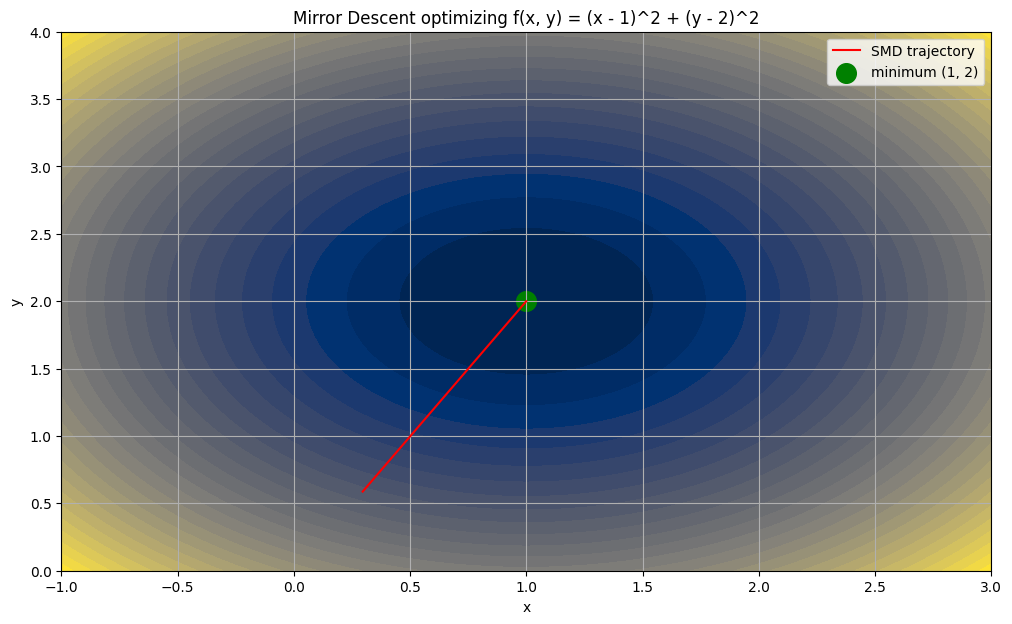

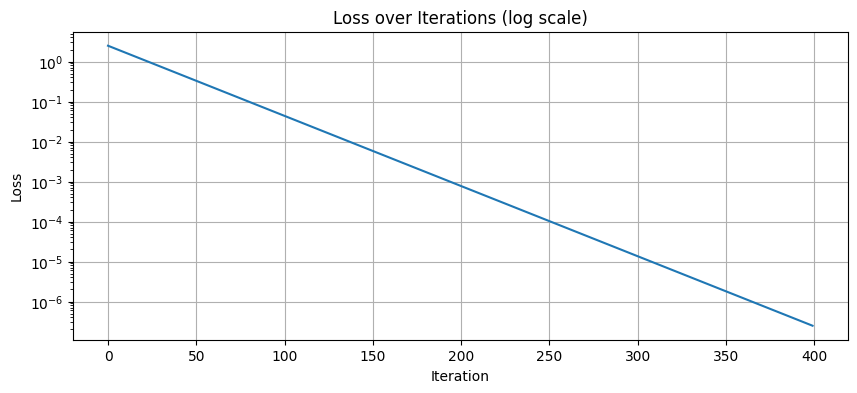

In [1]:
import torch
from torch.optim import Optimizer
import matplotlib.pyplot as plt
import numpy as np
import time

class MirrorDescent(Optimizer):
    def __init__(self, params, lr, mirror_map):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        defaults = dict(lr=lr, mirror_map=mirror_map)
        super(MirrorDescent, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
        for group in self.param_groups:
            lr = group['lr']
            mirror_map = group['mirror_map']
            for p in group['params']:
                if p.grad is not None:
                    grad = p.grad.data
                    p.data = mirror_map(p.data - lr * grad)
        return loss

# Mirror map (Euclidean)
def mirror_map(x):
    return x

# Quadratic loss: f(x, y) = (x-1)^2 + (y-2)^2
def quadratic(x):
    return (x[0] - 1)**2 + (x[1] - 2)**2

# Gradient: [2(x-1), 2(y-2)]
def grad_quadratic(x):
    dx = 2 * (x[0] - 1)
    dy = 2 * (x[1] - 2)
    return torch.tensor([dx, dy], dtype=torch.float32)

# Optimization variable
x = torch.nn.Parameter(torch.rand(2, dtype=torch.float32))

optimizer = MirrorDescent([x], lr=1e-2, mirror_map=mirror_map)

trajectory = [x.detach().clone()]
losses = []
tolerance = 1e-3

start_time = time.time()

for i in range(50000):
    optimizer.zero_grad()
    loss = quadratic(x)
    loss.backward()
    optimizer.step()

    trajectory.append(x.detach().clone())
    losses.append(loss.item())

    grad_norm = torch.norm(x.grad.detach())
    if grad_norm < tolerance:
        print(f"Early stopping at step {i}, final point: {x.detach()}, grad norm: {grad_norm:.6f}")
        break

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

# Thresholds
thresholds = [1.0, 0.1, 0.01, 0.001]
for t in thresholds:
    steps = next((i for i, l in enumerate(losses) if l < t), None)
    if steps is not None:
        print(f"Loss < {t} reached at iteration {steps}")
    else:
        print(f"Loss < {t} not reached")

# Convert trajectory
trajectory = torch.stack(trajectory).numpy()

# Plot optimization trajectory on contour
X, Y = np.meshgrid(np.linspace(-1, 3, 400), np.linspace(0, 4, 400))
Z = (X - 1)**2 + (Y - 2)**2

plt.figure(figsize=(12, 7))
plt.contourf(X, Y, Z, levels=30, cmap="cividis")
plt.plot(trajectory[:, 0], trajectory[:, 1], color="red", label="SMD trajectory")
plt.scatter([1], [2], color='green', label='minimum (1, 2)', s=200)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title("Mirror Descent optimizing f(x, y) = (x - 1)^2 + (y - 2)^2")
plt.grid(True)
plt.show()

# Loss curve
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss over Iterations (log scale)")
plt.grid(True)
plt.show()
